# Steps
1. Import train of persistent and non-persistent
2. Combine benign
3. Combine threats
4. Rename threats as malicious
5. Train model
6. Import testing data 
7. Process test data in same way to combine benign and malicious
8. Run testing
9. Export model

# Imports

In [22]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

# Import training for persistent and non persistent

In [9]:
persistent_train = pd.read_csv('unraveled_training.csv')
non_persistent_train = pd.read_csv('cic_ids_2017_train.csv')

# Create combined benign dataset and rename label to benign

<Axes: >

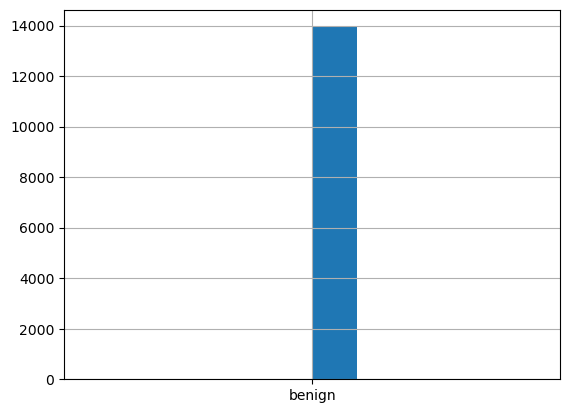

In [10]:
benign_mask = persistent_train['Label'] == 'Benign'
benign_persistent_train = persistent_train[benign_mask]
benign_mask = non_persistent_train['Label'] == 'BENIGN'
benign_non_persistent_train = non_persistent_train[benign_mask]
benign_df = pd.concat([benign_persistent_train, benign_non_persistent_train])
benign_df['Label'] = 'benign'
benign_df['Label'].hist()




# Create combined malicious dataset and rename label to malicious

<Axes: >

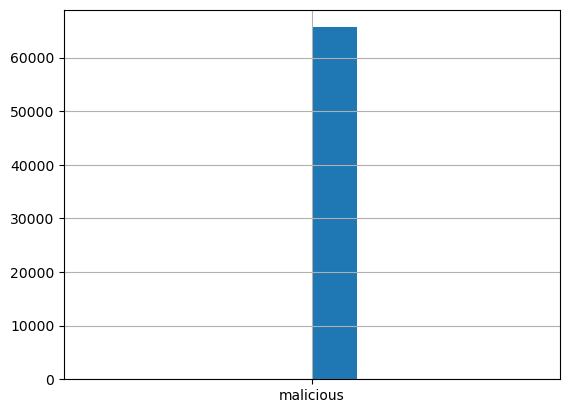

In [11]:
no_benign_mask = persistent_train['Label'] != 'Benign'
malicious_persistent_train = persistent_train[no_benign_mask]
no_benign_mask = non_persistent_train['Label'] != 'BENIGN'
malicious_non_persistent_train = non_persistent_train[no_benign_mask]
malicious_df = pd.concat([malicious_persistent_train, malicious_non_persistent_train])
malicious_df['Label'] = 'malicious'
malicious_df['Label'].hist()

# Combine benign and malicious training data

<Axes: >

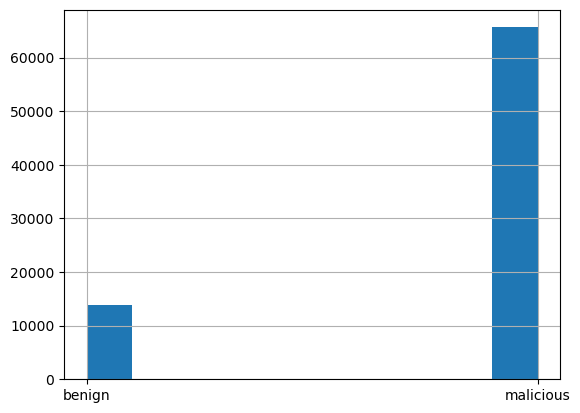

In [12]:
combined_train_df = pd.concat([benign_df, malicious_df])
combined_train_df['Label'].hist()

# Train model

In [13]:
predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(combined_train_df, fit_weighted_ensemble=False, time_limit=300)

No path specified. Models will be saved in: "AutogluonModels/ag-20250521_075606"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.4.0: Fri Apr 11 18:32:05 PDT 2025; root:xnu-11417.101.15~117/RELEASE_ARM64_T8132
CPU Count:          10
Memory Avail:       3.12 GB / 16.00 GB (19.5%)
Disk Space Avail:   148.82 GB / 460.43 GB (32.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize a

# Import and combine testing data

<Axes: >

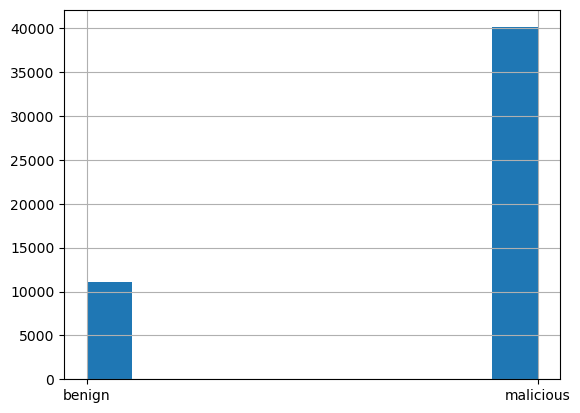

In [23]:
# Import testing data
persistent_test = pd.read_csv('unraveled_testing.csv')
non_persistent_test = pd.read_csv('cic_ids_2017_test.csv')

# Create benign
benign_mask = persistent_test['Label'] == 'Benign'
benign_persistent_test = persistent_test[benign_mask]
benign_mask = non_persistent_test['Label'] == 'BENIGN'
benign_non_persistent_test = non_persistent_test[benign_mask]
benign_df = pd.concat([benign_persistent_test, benign_non_persistent_test])
benign_df['Label'] = 'benign'

# Create malicious
no_benign_mask = persistent_test['Label'] != 'Benign'
malicious_persistent_test = persistent_test[no_benign_mask]
no_benign_mask = non_persistent_test['Label'] != 'BENIGN'
malicious_non_persistent_test = non_persistent_test[no_benign_mask]
malicious_df = pd.concat([malicious_persistent_test, malicious_non_persistent_test])
malicious_df['Label'] = 'malicious'

# Combine benign and malicious
combined_test_df = pd.concat([benign_df, malicious_df])
combined_test_df['Label'].hist()

In [24]:
predictor.leaderboard(combined_test_df)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.996082,0.995845,mcc,0.123257,0.026561,0.868571,0.123257,0.026561,0.868571,1,True,9
1,ExtraTreesGini,0.995851,0.995845,mcc,0.110115,0.025352,0.918515,0.110115,0.025352,0.918515,1,True,8
2,RandomForestGini,0.995735,0.995845,mcc,0.085127,0.026928,4.388798,0.085127,0.026928,4.388798,1,True,5
3,RandomForestEntr,0.995504,0.995845,mcc,0.085332,0.026579,3.180472,0.085332,0.026579,3.180472,1,True,6
4,NeuralNetTorch,0.994986,1.000000,mcc,0.276389,0.031460,105.739738,0.276389,0.031460,105.739738,1,True,12
5,CatBoost,0.993542,0.994459,mcc,0.010259,0.000852,2.687228,0.010259,0.000852,2.687228,1,True,7
6,XGBoost,0.993488,0.995845,mcc,0.045624,0.002571,0.469008,0.045624,0.002571,0.469008,1,True,11
7,LightGBMLarge,0.992904,0.995845,mcc,0.029134,0.001955,1.748952,0.029134,0.001955,1.748952,1,True,13
8,LightGBMXT,0.991123,0.993070,mcc,0.028661,0.002457,1.162128,0.028661,0.002457,1.162128,1,True,3
9,LightGBM,0.989966,0.995845,mcc,0.013053,0.001190,0.662966,0.013053,0.001190,0.662966,1,True,4


In [21]:
# will return the path to the cloned predictor, identical to save_path_clone_opt
path_clone_opt = predictor.clone_for_deployment(path='benign_malicious_model')

Cloned TabularPredictor located in '/Users/navya/Documents/Uni/Repos/modular_ids_framework/AutogluonModels/ag-20250521_075606' to 'benign_malicious_model'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="benign_malicious_model")
Clone: Keeping minimum set of models required to predict with best model 'NeuralNetTorch'...
Deleting model KNeighborsUnif. All files under /Users/navya/Documents/Uni/Repos/modular_ids_framework/benign_malicious_model/models/KNeighborsUnif will be removed.
Deleting model KNeighborsDist. All files under /Users/navya/Documents/Uni/Repos/modular_ids_framework/benign_malicious_model/models/KNeighborsDist will be removed.
Deleting model LightGBMXT. All files under /Users/navya/Documents/Uni/Repos/modular_ids_framework/benign_malicious_model/models/LightGBMXT will be removed.
Deleting model LightGBM. All files under /Users/navya/Documents/Uni/Repos/modular_ids_framework/benign_malicious_model/models/LightGBM will be removed.
Deleting mode